<a href="https://colab.research.google.com/github/kmay9270/AIML-Projects-USD-MSAAI-Team7/blob/mayur/Team7_WIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Statistical Coding Assignment: Regression Analysis of Medical Insurance Cost Across US regions

Students: **Emmanuel Sadek, Mayur Khare, and Jinyuan He**

Date: **09/30/2025**

This notebook serves as the technical foundation for our statistical coding assignment, focusing on the [Medical Insurance Cost dataset](https://www.kaggle.com/datasets/mosapabdelghany/medical-insurance-cost-dataset/) from Kaggle. This project is a collaborative effort by .

The analyses and code within this notebook directly support the sections of our technical report, which will include:

*   **Introduction:** Briefly introducing the problem and dataset.
*   **Data Cleaning/Preparation:** Detailing the steps taken to clean and prepare the data for analysis.
*   **Exploratory Data Analysis:** Presenting visualizations and summaries to understand the data's characteristics and relationships.
*   **Model Selection:** Explaining the rationale behind choosing specific models for predicting medical insurance costs.
*   **Model Analysis:** Evaluating the performance of the selected models.
*   **Conclusion and Recommendations:** Summarizing our findings and providing recommendations based on the analysis.

This notebook contains the executed code and outputs that will be included in the appendix of our technical report. We will use this notebook to perform the following steps:

*   **Load and Prepare the Data:** Import the dataset and perform any necessary cleaning or transformations.
*   **Conduct Exploratory Data Analysis:** Generate visualizations and descriptive statistics.
*   **Develop and Analyze Models:** Build and evaluate models for predicting medical insurance costs.

Through this notebook, we aim to systematically analyze the medical insurance cost dataset and generate the necessary outputs for our comprehensive technical report.

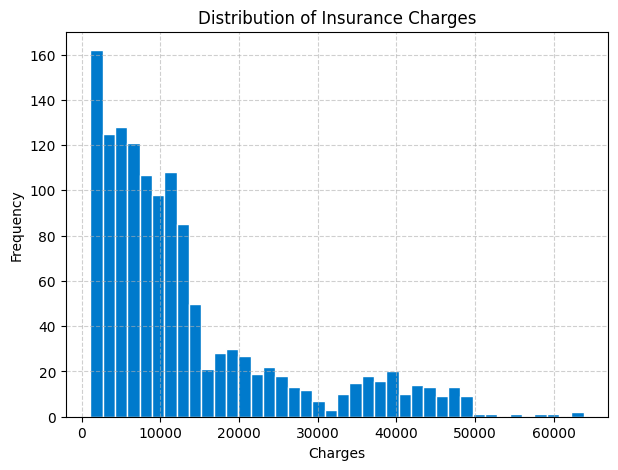

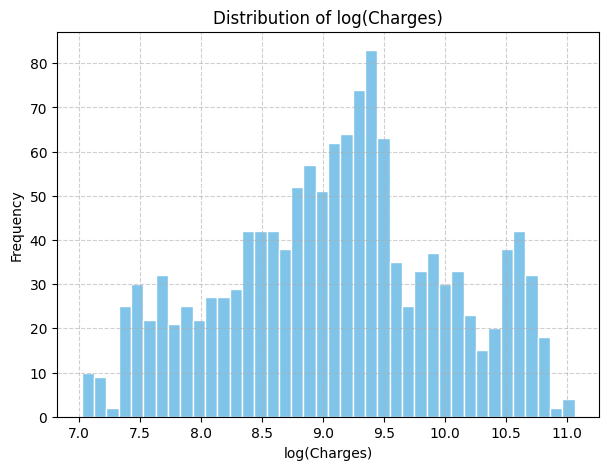

/tmp/ipython-input-2035812898.py:43: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=['Non-smoker','Smoker'], patch_artist=True,


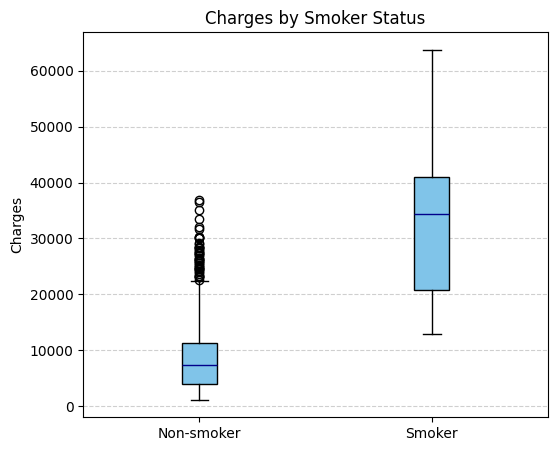

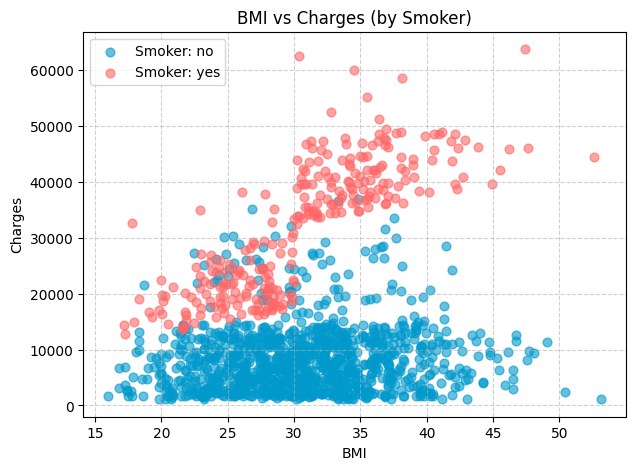

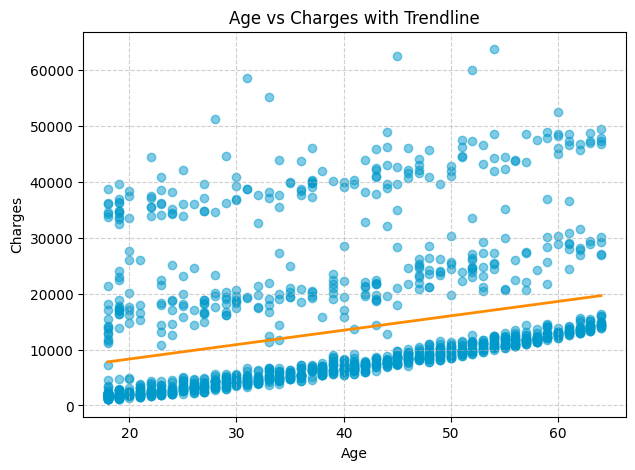

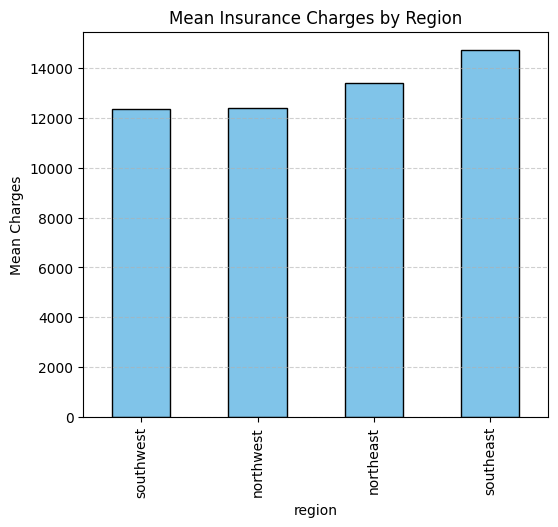

/tmp/ipython-input-2035812898.py:95: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_smoker = df.groupby(['age_band','smoker'])['charges'].mean().unstack()


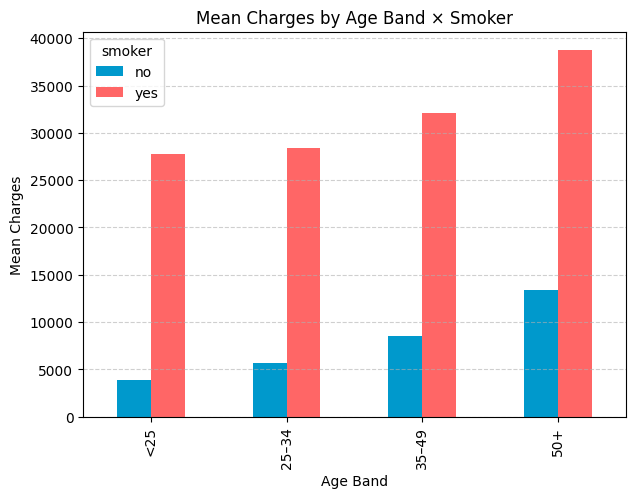

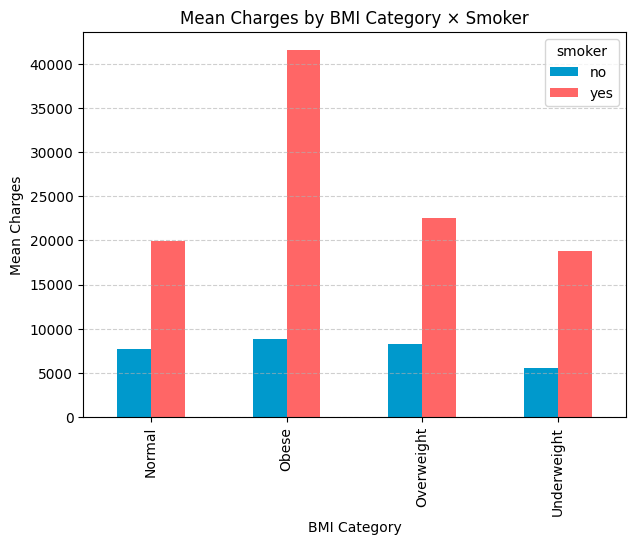

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

url = "https://raw.githubusercontent.com/kmay9270/AIML-Projects-USD-MSAAI-Team7/refs/heads/main/insurance.csv"
df = pd.read_csv(url)

# Clean column names
df.columns = [c.strip().lower() for c in df.columns]

# Convert categorical columns to lowercase
for c in ['sex', 'smoker', 'region']:
    df[c] = df[c].astype(str).str.lower().str.strip()

# -----------------------------------------------
# 1. Histogram – Distribution of Insurance Charges
# -----------------------------------------------
plt.figure(figsize=(7,5))
plt.hist(df['charges'], bins=40, color='#007ACC', edgecolor='white')
plt.title('Distribution of Insurance Charges')
plt.xlabel('Charges')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# ------------------------------------------------
# 2. Histogram (log scale) – log(Charges) for clarity
# ------------------------------------------------
plt.figure(figsize=(7,5))
plt.hist(np.log(df['charges']), bins=40, color='#80C4E9', edgecolor='white')
plt.title('Distribution of log(Charges)')
plt.xlabel('log(Charges)')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# ----------------------------------------------
# 3. Boxplot – Charges by Smoker Status
# ----------------------------------------------
plt.figure(figsize=(6,5))
data = [df.loc[df['smoker']=='no','charges'], df.loc[df['smoker']=='yes','charges']]
plt.boxplot(data, labels=['Non-smoker','Smoker'], patch_artist=True,
            boxprops=dict(facecolor='#80C4E9'), medianprops=dict(color='darkblue'))
plt.title('Charges by Smoker Status')
plt.ylabel('Charges')
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.show()

# ----------------------------------------------
# 4. Scatterplot – BMI vs Charges (by Smoker)
# ----------------------------------------------
plt.figure(figsize=(7,5))
for s, color in [('no','#0099CC'),('yes','#FF6666')]:
    subset = df[df['smoker']==s]
    plt.scatter(subset['bmi'], subset['charges'], label=f"Smoker: {s}", alpha=0.6, s=40, c=color)
plt.title('BMI vs Charges (by Smoker)')
plt.xlabel('BMI')
plt.ylabel('Charges')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# ----------------------------------------------
# 5. Scatterplot – Age vs Charges with Trendline
# ----------------------------------------------
plt.figure(figsize=(7,5))
plt.scatter(df['age'], df['charges'], alpha=0.5, color='#0099CC')
coef = np.polyfit(df['age'], df['charges'], 1)
plt.plot(np.unique(df['age']), np.polyval(coef, np.unique(df['age'])), color='darkorange', linewidth=2)
plt.title('Age vs Charges with Trendline')
plt.xlabel('Age')
plt.ylabel('Charges')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# ----------------------------------------------
# 6. Bar Chart – Mean Charges by Region
# ----------------------------------------------
region_mean = df.groupby('region')['charges'].mean().sort_values()
plt.figure(figsize=(6,5))
region_mean.plot(kind='bar', color='#80C4E9', edgecolor='black')
plt.title('Mean Insurance Charges by Region')
plt.ylabel('Mean Charges')
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.show()

# ----------------------------------------------
# 7. Bar Chart – Mean Charges by Age Band × Smoker
# ----------------------------------------------
age_bins = [0,25,35,50,np.inf]
age_labels = ["<25","25–34","35–49","50+"]
df['age_band'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=False)

age_smoker = df.groupby(['age_band','smoker'])['charges'].mean().unstack()
age_smoker.plot(kind='bar', figsize=(7,5), color=['#0099CC','#FF6666'])
plt.title('Mean Charges by Age Band × Smoker')
plt.ylabel('Mean Charges')
plt.xlabel('Age Band')
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.show()

# ----------------------------------------------
# 8. Bar Chart – Mean Charges by BMI Category × Smoker
# ----------------------------------------------
def bmi_cat(b):
    if b < 18.5: return "Underweight"
    elif b < 25: return "Normal"
    elif b < 30: return "Overweight"
    else: return "Obese"

df['bmi_cat'] = df['bmi'].apply(bmi_cat)

bmi_smoker = df.groupby(['bmi_cat','smoker'])['charges'].mean().unstack()
bmi_smoker.plot(kind='bar', figsize=(7,5), color=['#0099CC','#FF6666'])
plt.title('Mean Charges by BMI Category × Smoker')
plt.ylabel('Mean Charges')
plt.xlabel('BMI Category')
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.show()

In [ ]:
insurance_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
insurance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [ ]:
insurance_df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [ ]:
cat_cols = insurance_df.select_dtypes(include='object').columns
for col in cat_cols:
    print(f"\nValue counts for {col}:")
    print(insurance_df[col].value_counts())


Value counts for sex:
sex
male      676
female    662
Name: count, dtype: int64

Value counts for smoker:
smoker
no     1064
yes     274
Name: count, dtype: int64

Value counts for region:
region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64


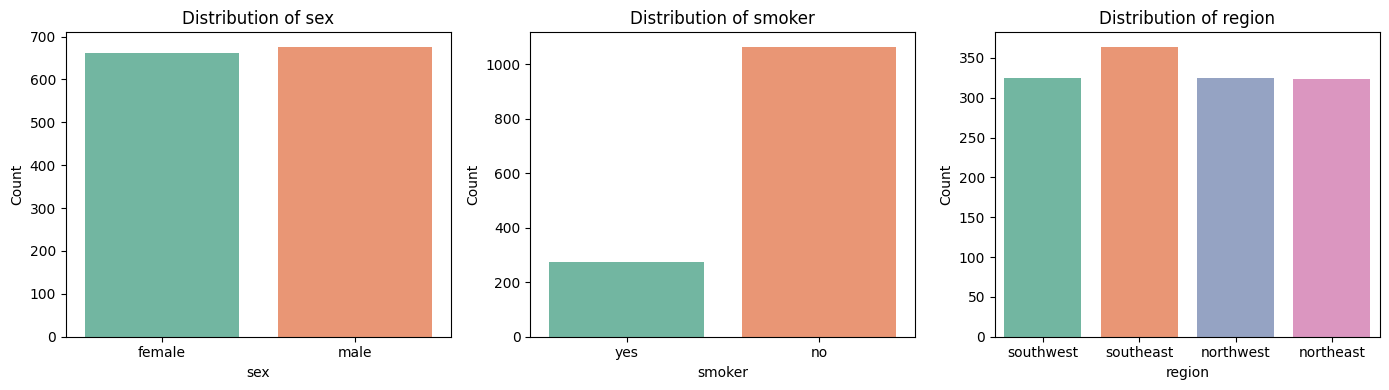

In [ ]:
fig, axes = plt.subplots(1, len(cat_cols), figsize=(14,4))
for i, col in enumerate(cat_cols):
    sns.countplot(x=col, hue=col, data=insurance_df, palette='Set2', legend=False, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")
plt.tight_layout()
plt.show()

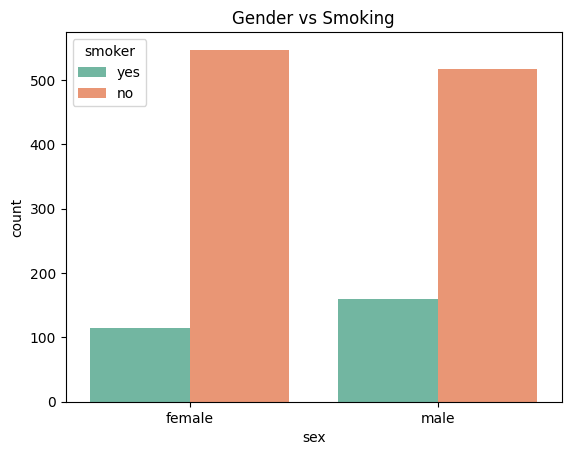

In [ ]:
sns.countplot(x='sex', hue='smoker', data=insurance_df, palette='Set2')
plt.title("Gender vs Smoking")
plt.show()

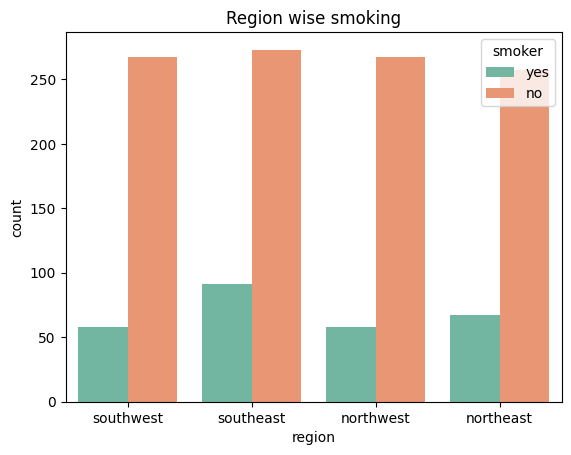

In [ ]:
sns.countplot(x='region', hue='smoker', data=insurance_df, palette='Set2')
plt.title("Region wise smoking")
plt.show()

/tmp/ipython-input-4253806124.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='region', y='charges',data=insurance_df, palette='Set2', legend=False)


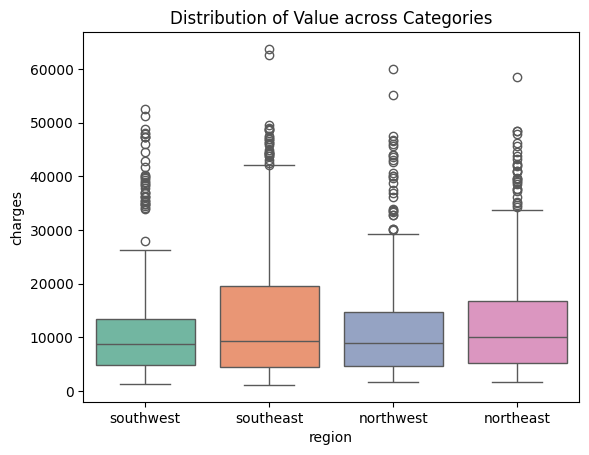

In [ ]:
#sns.boxplot(x='region', y='charges', data=insurance_df, palette='Set2')
sns.boxplot(x='region', y='charges',data=insurance_df, palette='Set2', legend=False)
plt.title("Distribution of Value across Categories")
plt.show()